# EMBS-BHI-2025: Robust and Reproducible AI Tutorial¶
Tutorial instructors: Ernest Namdar and Pascal Tyrrell

## Assessing Segmentation Results

This notebook consolidates previously exported quality metrics and performs secondary analyses to contextualise BraTS Pediatric segmentation performance.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import ttest_ind, mannwhitneyu, shapiro


In [4]:
PROJECT_ROOT = Path('.').resolve()
if not (PROJECT_ROOT / 'results').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

RESULTS_DIR = PROJECT_ROOT / 'results'
metrics_path = RESULTS_DIR / 'evaluation_metrics.csv'
gt_path = RESULTS_DIR / 'groundtruthEDA.csv'
inf_path = RESULTS_DIR / 'inferenceEDA.csv'

print('Metrics file:', metrics_path)
print('Ground-truth EDA file:', gt_path)
print('Inference EDA file:', inf_path)


Metrics file: /home/ernest/Desktop/Projects/EMBS_BHI_2025_Tutorial/Part2-Segmentation/results/evaluation_metrics.csv
Ground-truth EDA file: /home/ernest/Desktop/Projects/EMBS_BHI_2025_Tutorial/Part2-Segmentation/results/groundtruthEDA.csv
Inference EDA file: /home/ernest/Desktop/Projects/EMBS_BHI_2025_Tutorial/Part2-Segmentation/results/inferenceEDA.csv


In [6]:
def strip_case_id(value: str) -> str:
    if isinstance(value, str):
        if value.endswith('.nii.gz'):
            return value[:-7]
        if value.endswith('.nii'):
            return value[:-4]
    return value

metrics_df = pd.read_csv(metrics_path)
gt_df = pd.read_csv(gt_path)
inf_df = pd.read_csv(inf_path)

metrics_df['case_id'] = metrics_df['case_id'].apply(strip_case_id)
gt_df['case_id'] = gt_df['case_id'].apply(strip_case_id)
inf_df['case_id'] = inf_df['case_id'].apply(strip_case_id)

print(metrics_df.shape, gt_df.shape, inf_df.shape)
metrics_df.head()


(261, 15) (261, 10) (261, 10)


,dice,jaccard,rvd,avd_voxels,hausdorff,hausdorff95,nsd,surface_dice,msd,lesion_recall,lesion_precision,case_id,voxel_spacing_x,voxel_spacing_y,voxel_spacing_z
0,0.939661,0.886189,-0.001710,220,10.440307,1.414214,0.918363,0.919463,0.432630,0.111111,1.0,BraTS-PED-00001-000,1.0,1.0,1.0
1,0.974891,0.951011,-0.015203,266,4.000000,1.000000,0.995115,0.995155,0.159473,0.500000,1.0,BraTS-PED-00002-000,1.0,1.0,1.0
2,0.943192,0.892491,0.011384,189,84.693565,1.414214,0.931390,0.933062,0.480986,0.200000,1.0,BraTS-PED-00003-000,1.0,1.0,1.0
3,0.948302,0.901687,0.005383,844,40.422766,2.449490,0.819089,0.822027,0.715332,0.100000,1.0,BraTS-PED-00004-000,1.0,1.0,1.0
4,0.945409,0.896470,-0.002320,40,5.830952,1.414214,0.920215,0.921760,0.416009,0.250000,1.0,BraTS-PED-00005-000,1.0,1.0,1.0


In [10]:
def add_prefix(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    renamed = df.rename(columns={col: f'{prefix}{col}' if col != 'case_id' else col for col in df.columns})
    return renamed

prefixed_gt = add_prefix(gt_df, 'GT_')
prefixed_inf = add_prefix(inf_df, 'Pr_')

merged = metrics_df.merge(prefixed_gt, on='case_id', how='left').merge(prefixed_inf, on='case_id', how='left')

empty_cols = [col for col in merged.columns if merged[col].isna().all() and col not in {'GT_tumor_volume_mm3', 'Pr_tumor_volume_mm3'}]
if empty_cols:
    print('Columns with all NaN values:', empty_cols[:10], '...')

merged_path = RESULTS_DIR / 'assessment_merged_metrics.csv'
merged.to_csv(merged_path, index=False)
print(f'Saved merged dataset to {merged_path.relative_to(PROJECT_ROOT)}')
merged.head()


Saved merged dataset to results/assessment_merged_metrics.csv


,dice,jaccard,rvd,avd_voxels,hausdorff,hausdorff95,nsd,surface_dice,msd,lesion_recall,...,GT_bbox_size_z,Pr_voxel_spacing_x,Pr_voxel_spacing_y,Pr_voxel_spacing_z,Pr_voxel_volume_mm3,Pr_tumor_volume_mm3,Pr_island_count,Pr_bbox_size_x,Pr_bbox_size_y,Pr_bbox_size_z
0,0.939661,0.886189,-0.001710,220,10.440307,1.414214,0.918363,0.919463,0.432630,0.111111,...,89,1.0,1.0,1.0,1.0,128447.0,2,92,88,85
1,0.974891,0.951011,-0.015203,266,4.000000,1.000000,0.995115,0.995155,0.159473,0.500000,...,34,1.0,1.0,1.0,1.0,17231.0,1,36,31,34
2,0.943192,0.892491,0.011384,189,84.693565,1.414214,0.931390,0.933062,0.480986,0.200000,...,75,1.0,1.0,1.0,1.0,16791.0,1,34,31,32
3,0.948302,0.901687,0.005383,844,40.422766,2.449490,0.819089,0.822027,0.715332,0.100000,...,69,1.0,1.0,1.0,1.0,157643.0,1,76,80,67
4,0.945409,0.896470,-0.002320,40,5.830952,1.414214,0.920215,0.921760,0.416009,0.250000,...,28,1.0,1.0,1.0,1.0,17199.0,1,32,45,26


## Bland-Altman Plot
Bland-Altman plots compare the agreement between two measurement techniques by plotting their mean against their difference, highlighting systematic bias or heteroscedasticity. Here we assess volume estimates from ground-truth and model predictions.

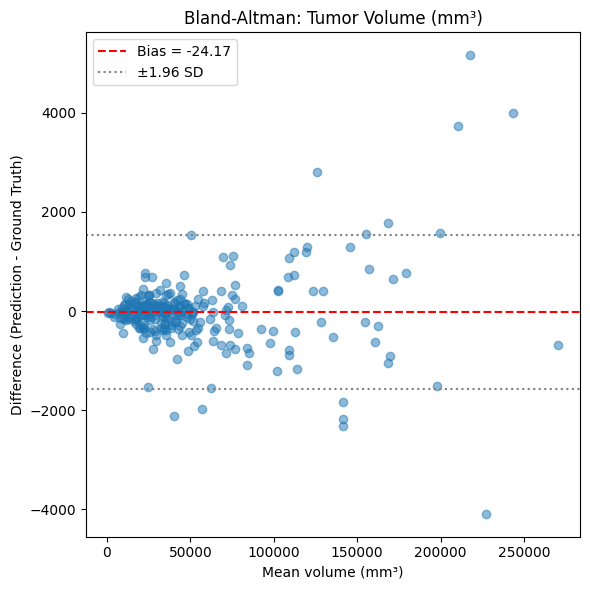

In [13]:
def bland_altman_plot(df, col_true, col_pred, ax=None, title='Bland-Altman Plot'):
    subset = df.dropna(subset=[col_true, col_pred])
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    mean_values = (subset[col_true] + subset[col_pred]) / 2
    diff_values = subset[col_pred] - subset[col_true]
    bias = diff_values.mean()
    sd = diff_values.std()

    ax.scatter(mean_values, diff_values, alpha=0.5)
    ax.axhline(bias, color='red', linestyle='--', label=f'Bias = {bias:.2f}')
    ax.axhline(bias + 1.96 * sd, color='gray', linestyle=':', label='±1.96 SD')
    ax.axhline(bias - 1.96 * sd, color='gray', linestyle=':')
    ax.set_xlabel('Mean volume (mm³)')
    ax.set_ylabel('Difference (Prediction - Ground Truth)')
    ax.set_title(title)
    ax.legend()
    return ax

fig, ax = plt.subplots(figsize=(6, 6))
bland_altman_plot(merged, 'GT_tumor_volume_mm3', 'Pr_tumor_volume_mm3', ax=ax,
                  title='Bland-Altman: Tumor Volume (mm³)')
plt.tight_layout()


## VOI versus ROI
A Volume of Interest (VOI) spans a 3D region across multiple slices, whereas a Region of Interest (ROI) typically refers to a 2D slice-level annotation. VOIs preserve volumetric context crucial for 3D segmentation analysis.

## Dice Distributions by Island Count
We compare Dice scores between VOIs with a single connected component and those with multiple islands.

/tmp/ipykernel_1459943/2106586068.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['1 island', '>1 islands'])


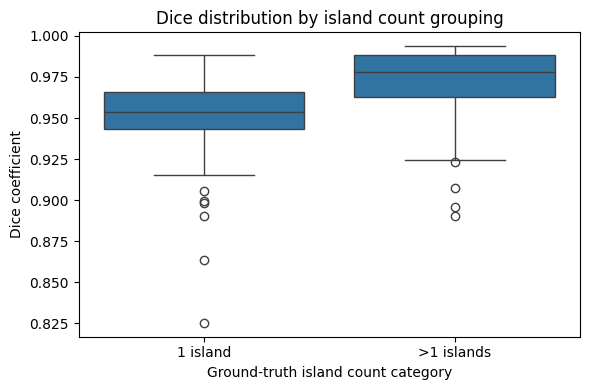

In [17]:
merged['GT_is_single_island'] = merged['GT_island_count'] == 1

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=merged.dropna(subset=['GT_is_single_island', 'dice']),
            x='GT_is_single_island', y='dice', ax=ax)
ax.set_xticklabels(['1 island', '>1 islands'])
ax.set_xlabel('Ground-truth island count category')
ax.set_ylabel('Dice coefficient')
ax.set_title('Dice distribution by island count grouping')
plt.tight_layout()


## NSD Comparisons
We probe whether Normalised Surface Dice differs between single-island and multi-island VOIs. Normality is checked via Shapiro-Wilk before selecting between a t-test or Mann-Whitney U test.

In [20]:
single_nsd = merged.loc[merged['GT_is_single_island'], 'nsd'].dropna()
multi_nsd = merged.loc[~merged['GT_is_single_island'], 'nsd'].dropna()

print('Samples: single =', len(single_nsd), ', multi =', len(multi_nsd))

if len(single_nsd) > 3:
    shapiro_single = shapiro(single_nsd)
else:
    shapiro_single = (np.nan, np.nan)

if len(multi_nsd) > 3:
    shapiro_multi = shapiro(multi_nsd)
else:
    shapiro_multi = (np.nan, np.nan)

print('Shapiro single island p-value:', shapiro_single[1])
print('Shapiro multi island p-value:', shapiro_multi[1])

if len(single_nsd) < 2 or len(multi_nsd) < 2:
    test_name = 'insufficient samples'
    test_stat = np.nan
    p_value = np.nan
elif (not np.isnan(shapiro_single[1]) and shapiro_single[1] > 0.05) and      (not np.isnan(shapiro_multi[1]) and shapiro_multi[1] > 0.05):
    test_name = 'Welch t-test'
    test_stat, p_value = ttest_ind(single_nsd, multi_nsd, equal_var=False)
else:
    test_name = 'Mann-Whitney U'
    test_stat, p_value = mannwhitneyu(single_nsd, multi_nsd, alternative='two-sided')

print(f'Chosen test: {test_name}')
print(f'Statistic: {test_stat:.4f}, p-value: {p_value}')


Samples: single = 115 , multi = 146
Shapiro single island p-value: 1.142090999889039e-12
Shapiro multi island p-value: 1.0954413994031765e-06
Chosen test: Mann-Whitney U
Statistic: 13537.0000, p-value: 2.025813013854697e-17
